In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np 

DIM = 20 

class FixedRot(datasets.VisionDataset):
    num_targets = 10
    def __init__(self,*args,angle =pi/3,N=50000,size=(7,7),
                 train=True,dataseed=0, fp=None,**kwargs):
        super().__init__(*args,**kwargs)

        if fp is not None:
            npz = fp
            resx = np.linspace(-2., 1., 20)
            self.data = np.zeros([N, 1, DIM, DIM])
            for i in range(0, N):
                #print(type(npz[i]), npz[i])
                resy = (np.rint(npz[i]*9)).astype(int) // 2
                resy = -resy + 9
                for xi in range(0, DIM):
                    #print(xi, resy.shape)
                    self.data[i][0][resy[xi]][xi] = 1.

        self.data = torch.Tensor(self.data)
        #if not train: 
        #    dataseed += 1
        #    N = int(0.2*N)
        torch.manual_seed(dataseed)
        angles = torch.ones(N)*angle # torch.rand(N)*2*np.pi
        #self.data = torch.rand(N,1,*size)-.5
        print(N, self.data.shape)
        with torch.no_grad():
            # Build affine matrices for random translation of each image
            affineMatrices = torch.zeros(N,2,3)
            affineMatrices[:,0,0] = angles.cos()
            affineMatrices[:,1,1] = angles.cos()
            affineMatrices[:,0,1] = angles.sin()
            affineMatrices[:,1,0] = -angles.sin()
            
            flowgrid = F.affine_grid(affineMatrices, size = self.data.shape) # self.data.size()
            self.data_rot = F.grid_sample(self.data, flowgrid)

    def __getitem__(self,idx):
        return self.data[idx], self.data_rot[idx] # , self.data[idx]
    
    def __len__(self):
        return len(self.data)
    
    def default_aug_layers(self):
        return RandomRotateTranslate(0)# no translation


npz of shape (10000, 20)
8500 torch.Size([8500, 1, 20, 20])


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


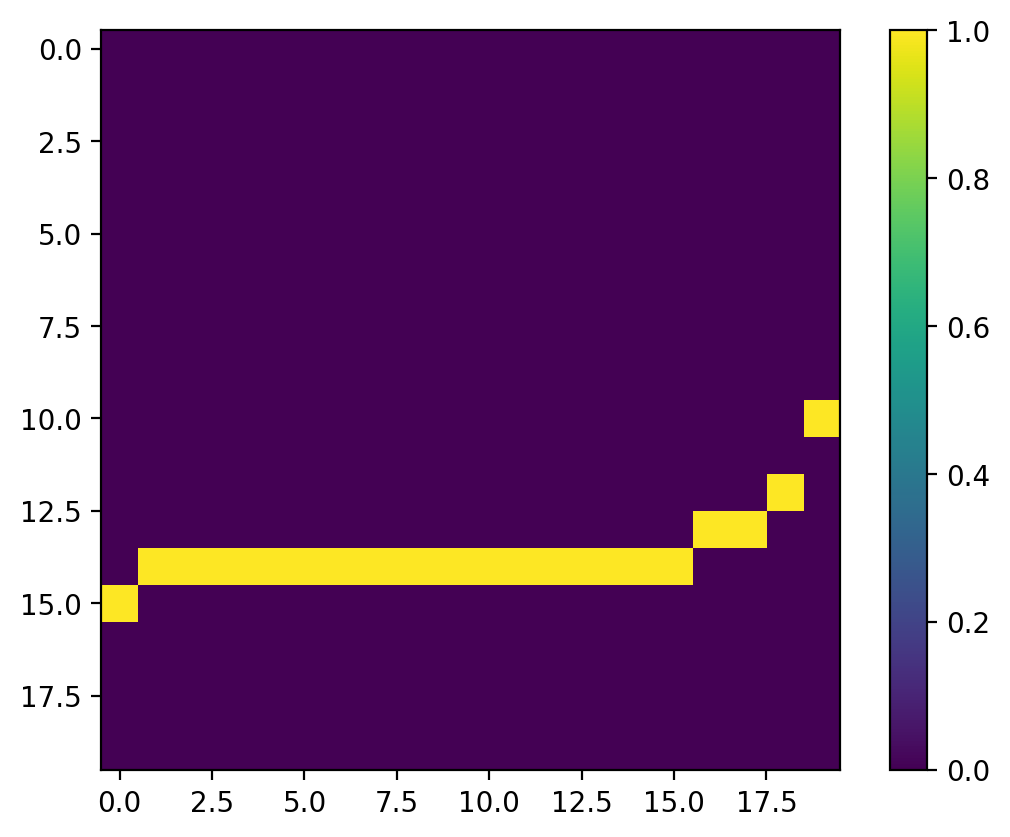

In [4]:
test_rot = FixedRot

#npz = np.load("ode10x20.npz")
npz = np.load("ode10000x20.npz")

npzshape = npz['arr_0'].shape
print(f"npz of shape {npzshape}")

ang_n = 18
ang = pi/ang_n
dataset1 = test_rot('../data', fp=npz['arr_0'], N=8500, train=True, size=(DIM,DIM), angle=ang)

data, data_rot = dataset1.__getitem__(2000)

imshow(data.squeeze())
colorbar()

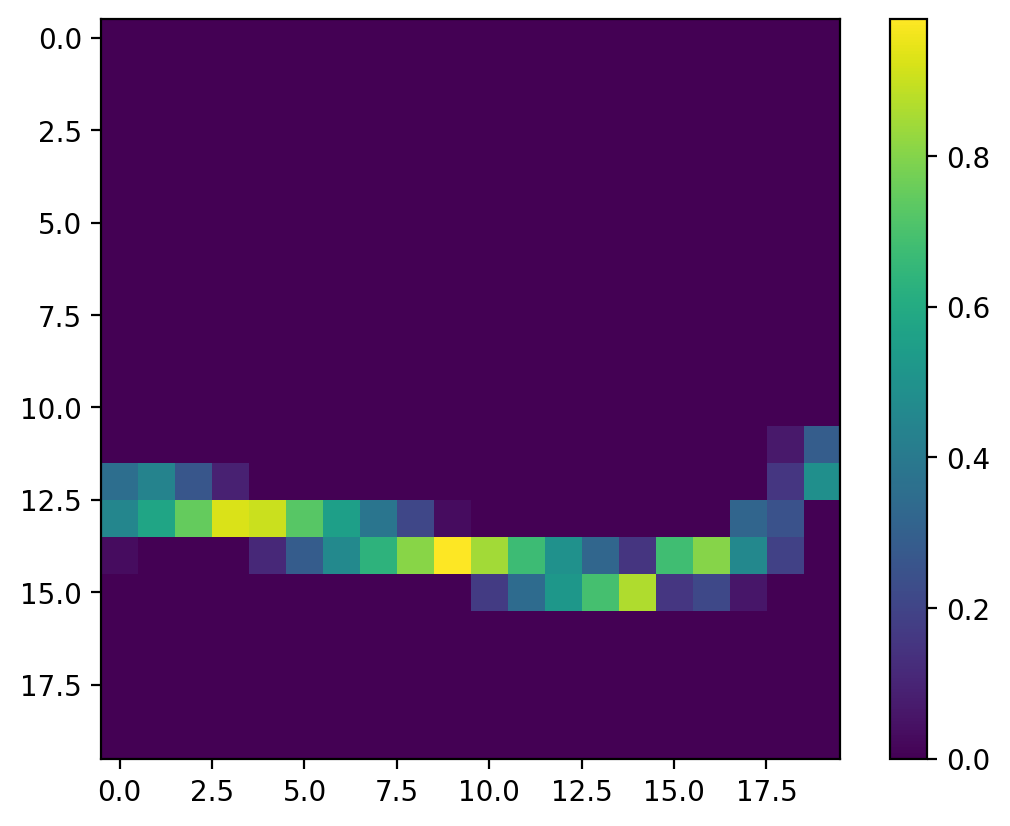

In [5]:
imshow(data_rot.squeeze())
colorbar()

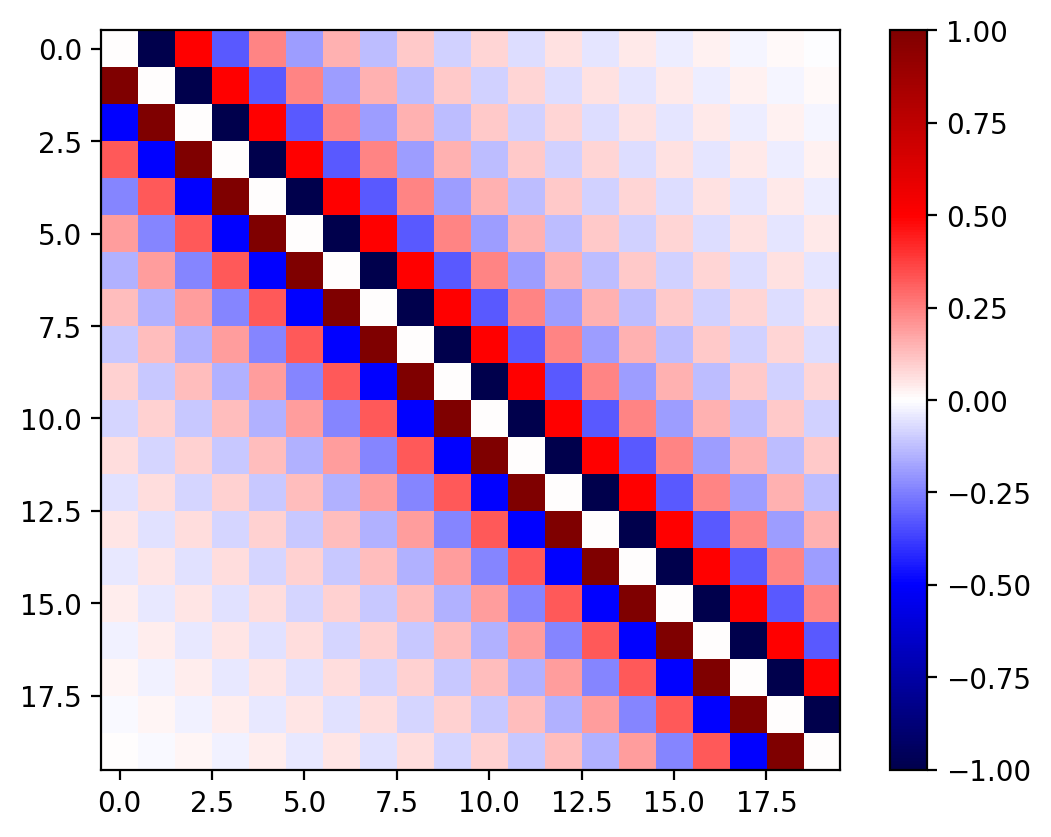

In [6]:
# exact rotation generator
L0 = lambda d,z: sum([2*pi*p/d**2 * sin(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)

DIM = 20
d = 20
z = arange(d)[:,newaxis]-arange(d)
imshow(L0(2*d,z), cmap = 'seismic',vmin=-1, vmax=1)
colorbar()

In [7]:
(arange(d)[:,newaxis] - arange(d)).shape

(20, 20)

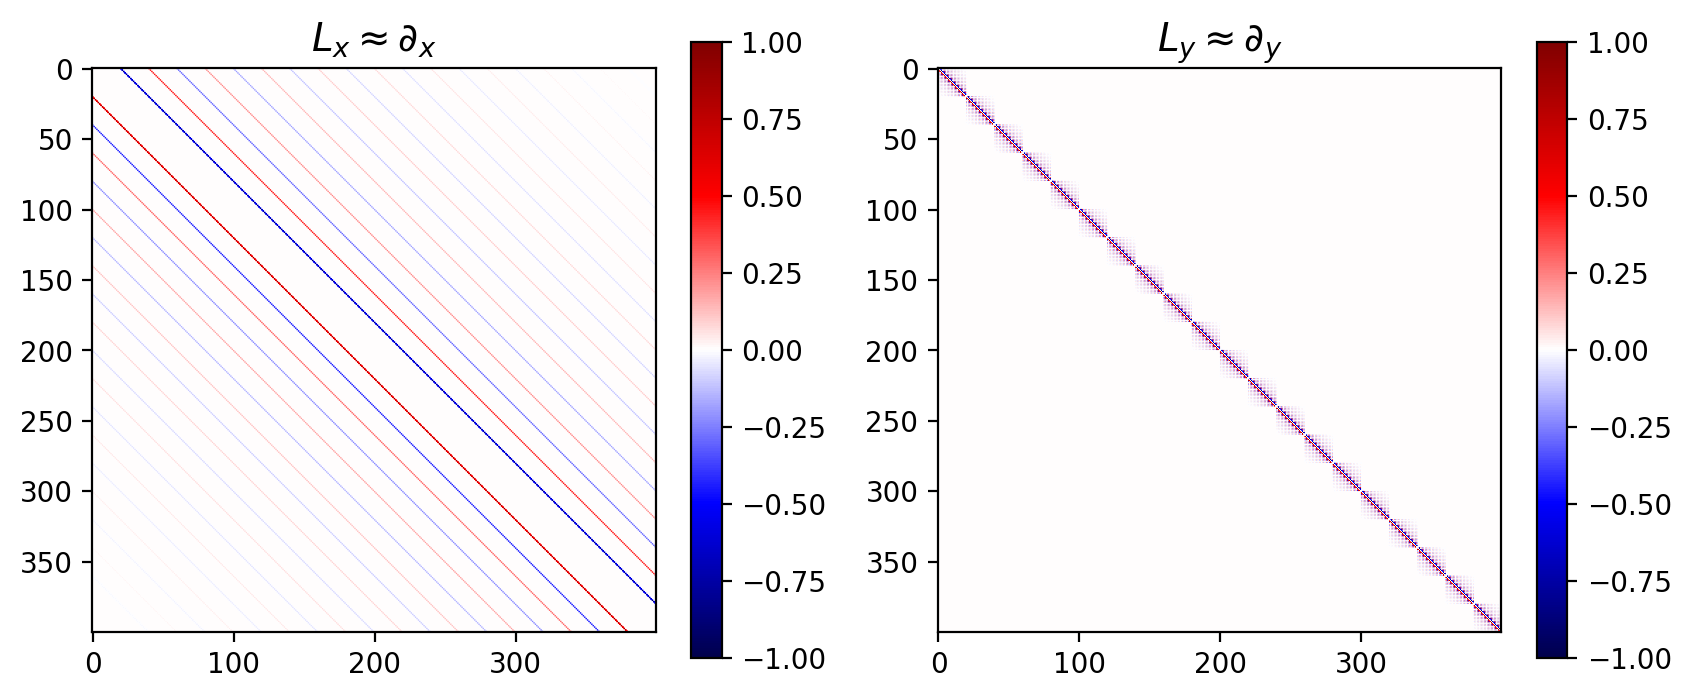

In [8]:
d = DIM
coords = mgrid[:d,:d] - d/2
x,y = coords.reshape((2,-1))

dx = (x[:,newaxis]-x) * (y[:,newaxis]==y) # make sure distance calculated only for the same y
dy = (y[:,newaxis]-y) * (x[:,newaxis]==x) # ... same x

figure(figsize=(10,4))
subplot(121)

Lx = L0(2*d,dx)
imshow(Lx,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_x\approx \partial_x$',size=14)

subplot(122)

Ly = L0(2*d,dy)
imshow(Ly,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_y\approx \partial_y$',size=14);


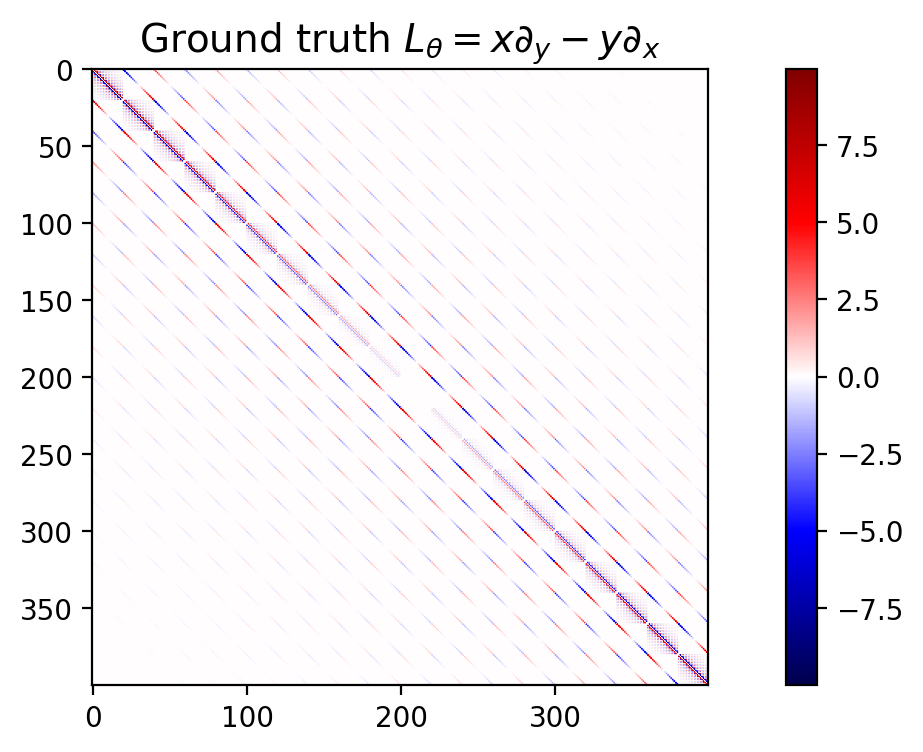

In [9]:

figure(figsize=(10,4))

yLx = diag(y) @ Lx
xLy = diag(x) @ Ly

L_rot = xLy - yLx
imshow(L_rot,cmap = 'seismic')#,vmin=-1, vmax=1)
colorbar()
title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);

In [10]:
from time import time
class trainer():
    def __init__(self, model, device, optimizer, dataset_class = None, 
                 train_loader=None, test_loader=None,
                 batch_size = 64, test_batch_size = 1000,loss_func = F.nll_loss,
                ):
        """
        usage:
            t = trainer(...)
            t.fit(epochs)
            
        methods:
            .fit(epochs) : train + test; print results; stores results in trainer.history <dict>
            .train(epoch)
            .test()
        """
        self.device = device #torch.device(device)
        self.optimizer = optimizer
        self.model = model
        self.loss_func = loss_func

        self.scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        self.history = {'train loss':[], 'test loss':[], 'train acc':[], 'test acc':[], 'train time':[]}
        
        if dataset_class:
            self.make_dataloaders(dataset_class, batch_size, test_batch_size)
        else:
            self.train_loader = train_loader 
            self.test_loader = test_loader
        
    def make_dataloaders(self, dataset_class, batch_size, test_batch_size):
        train_kwargs = {'batch_size': batch_size}
        test_kwargs = {'batch_size': test_batch_size}
        if self.device.type =='cuda':        
            cuda_kwargs = {'num_workers': 1,
                           'pin_memory': True,
                           'shuffle': True}
            train_kwargs.update(cuda_kwargs)
            test_kwargs.update(cuda_kwargs)
        
        print('Creating data loaders...',end='')
        dataset1 = dataset_class('../data', train=True, download=True,)
        dataset2 = dataset_class('../data', train=False,)

        self.train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
        self.test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        print('Done')

#         self.optimizer = optimizer
#         self.model, self.device, self.train_loader,  = model, device, train_loader,
#         self.test_loader = test_loader
        
    def progbar(self,percent, N=10):
        n = int(percent//N)
        return '[' + '='*n + '>' +'.'*(N-n-1) +']'
    
    def train(self,epoch):
        self.model.train()
        training_loss = 0
        correct = 0
        t0 = time()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            if type(data)==list:
                data = [d.to(self.device) for d in data]
            else:
                data = data.to(self.device)
            if type(target)==list:
                target = [d.to(self.device) for d in target]
            else:
                target = target.to(self.device)
                
#             data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            training_loss += loss.sum().item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss.backward(retain_graph=True)
            self.optimizer.step()
            if batch_idx % 10 == 0:
                perc = 100. * batch_idx / len(self.train_loader)
                t1 = time()
                print('Train Epoch: {} {} {:.1f}s [{}/{} ({:.0f}%)]\tLoss: {:.4g}'.format(
                    epoch, self.progbar(perc), t1-t0,
                    batch_idx * len(data), len(self.train_loader.dataset), # n/N
                    perc, # % passed
                    loss.item()), end='\r')
        
        training_loss /= len(self.train_loader.dataset)
        acc = correct / len(self.train_loader.dataset)    
        print('\nTraining: loss: {:.4g}, Acc: {:.2f}%'.format(training_loss, 100.*acc))
            
        return {'loss':training_loss, 'acc':acc , 'time':t1-t0}
                
        
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                if type(data)==list:
                    data = [d.to(self.device) for d in data]
                else:
                    data = data.to(self.device)
                if type(target)==list:
                    target = [d.to(self.device) for d in target]
                else:
                    target = target.to(self.device)
                #data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += self.loss_func(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        
        test_loss /= len(self.test_loader.dataset)
        test_acc = correct / len(self.test_loader.dataset)
        
        print('Test loss: {:.4g}, Test acc.: {:.2f}%'.format( test_loss, 100.*test_acc))
        return {'loss':test_loss, 'acc':test_acc}
    
    def fit(self,epochs=1):
        for epoch in range(1, epochs + 1):
            r = self.train(epoch)
            self.history['train loss'] += [r['loss']]
            self.history['train acc'] += [r['acc']]
            self.history['train time'] += [r['time']]
            
            r = self.test()
            self.history['test loss'] += [r['loss']]
            self.history['test acc'] += [r['acc']]
            self.scheduler.step()

In [11]:
# includes residual
       
class Lconv_core(nn.Module):
    """ L-conv layer with full L """
    def __init__(self,d,num_L=1,cin=1,cout=1,rank=8):
        """
        L:(num_L, d, d)
        Wi: (num_L, cout, cin)
        """
        super().__init__()
        self.L = nn.Parameter(torch.Tensor(num_L, d, d))
        self.Wi = nn.Parameter(torch.Tensor(num_L, cout, cin))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L) 
        nn.init.kaiming_normal_(self.Wi)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        # h = (x + Li x Wi) W0
        y = torch.einsum('kdf,bcf,koc->bod', self.L, x, self.Wi ) +x #+ self.b        
        return y


In [12]:
# includes residual

class Lconv_grid(nn.Module):
    """ L-conv using an inferred grid in the data. 
    """
    def __init__(self,idx, k,d,cin,cout):
        super().__init__()
        self.idx = idx
        self.L_sparse = nn.Parameter(torch.Tensor(*idx.shape, k)) 
        self.W = nn.Parameter(torch.Tensor(k, cin, cout))
        self.b = nn.Parameter(torch.Tensor(1, cout, 1))
        # the bias is not complete, but more efficient 
#         self.b = nn.Parameter(torch.Tensor(1,k, cout, 1))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L_sparse, mode='fan_in') 
        nn.init.kaiming_normal_(self.W)      
        nn.init.kaiming_normal_(self.b)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        return torch.einsum('bcdi,dik,kco->bod',x[:,:,self.idx], self.L_sparse, self.W ) + self.b


In [13]:
class Reshape(nn.Module):
    def __init__(self,shape=None):
        self.shape = shape
        super().__init__()
    def forward(self,x):
        return x.view(-1,*self.shape)

In [36]:
r=0 # r = 1e-2*torch.randn(*dataset1.data.shape)
X,Y = (dataset1.data-127.5)/255+r, (dataset1.data_rot-127.5)/255 +r
X,Y = X.view(X.shape[0], -1), Y.view(Y.shape[0], -1)  

In [41]:
n = 10_000
R0 = torch.linalg.pinv(X[:n].t()@X[:n]) @ (X[:n].t()@Y[:n])
#R0 = torch.inverse(X[:n].t()@X[:n]) @ (X[:n].t()@Y[:n])
L_linreg = (R0.numpy() - eye(R0.shape[0]))/ang

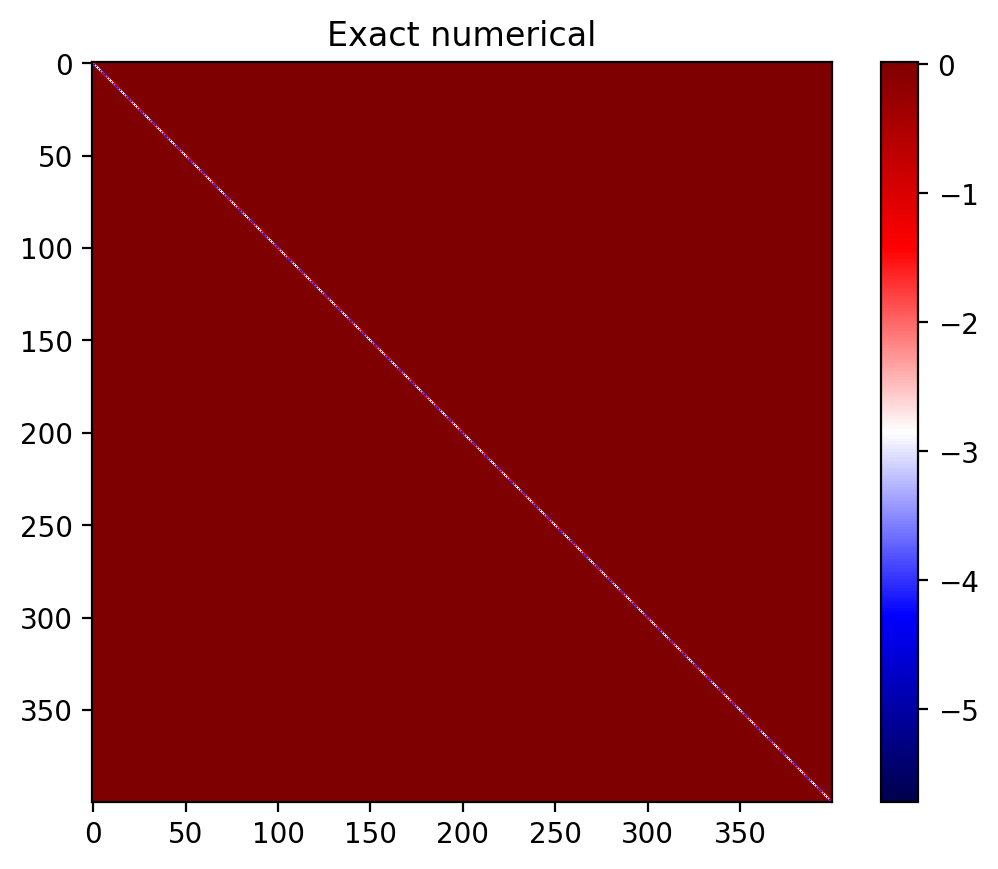

In [42]:
title('Exact numerical')
imshow(L_linreg, cmap='seismic')#, vmin = -m, vmax = m)
colorbar()

In [68]:

# dataset = CIFAR100
dataset = FixedRot #AugRotMNIST__0
# dataset = AugRotMNIST__0
num_targets = dataset.num_targets

batch_size = 32

test_batch_size = 1000 #150
device = torch.device("cuda")
# device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
# if use_cuda:
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

ang_n = 45
ang = pi/ang_n
dataset1 = dataset('../data', fp=npz['arr_0'], N=8500, train=True, size=(DIM,DIM), angle=ang)
dataset2 = dataset('../data', fp=npz['arr_0'], N=8500, train=False, size=(DIM,DIM), angle=ang)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


8500 torch.Size([8500, 1, 20, 20])
8500 torch.Size([8500, 1, 20, 20])


In [69]:
s = dataset1[0][0].shape
d = prod(s)
lc = Lconv_core(d=d,num_L=2, cin=1, cout=1)
model = nn.Sequential(
    nn.Flatten(2),
    lc,
    Reshape(s)
).to(device)
optimizer = optim.Adam(model.parameters(),lr = 5e-3)


In [70]:
t = trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)
t.fit(20)


Train Epoch: 1 [=========>] 0.3s [8320/8500 (98%)]	Loss: 3.182e-05
Training: loss: 6.055e-05, Acc: 35098.47%
Test loss: 0.01818, Test acc.: 35098.47%
Train Epoch: 2 [=========>] 0.3s [8320/8500 (98%)]	Loss: 1.313e-05
Training: loss: 5.578e-07, Acc: 35098.47%
Test loss: 0.008336, Test acc.: 35098.47%
Train Epoch: 3 [=========>] 0.3s [8320/8500 (98%)]	Loss: 1.054e-05
Training: loss: 1.802e-07, Acc: 35098.47%
Test loss: 0.001684, Test acc.: 35098.47%
Train Epoch: 4 [=========>] 0.3s [8320/8500 (98%)]	Loss: 1.414e-06
Training: loss: 6.089e-08, Acc: 35098.47%
Test loss: 0.0006534, Test acc.: 35098.47%
Train Epoch: 5 [=========>] 0.3s [8320/8500 (98%)]	Loss: 1.059e-06
Training: loss: 3.015e-08, Acc: 35098.47%
Test loss: 0.0004395, Test acc.: 35098.47%
Train Epoch: 6 [=========>] 0.3s [8320/8500 (98%)]	Loss: 2.746e-07
Training: loss: 2.072e-08, Acc: 35098.47%
Test loss: 0.0002024, Test acc.: 35098.47%
Train Epoch: 7 [=========>] 0.3s [8320/8500 (98%)]	Loss: 6.525e-07
Training: loss: 1.502e-08

Text(0.5, 0, 'Epochs')

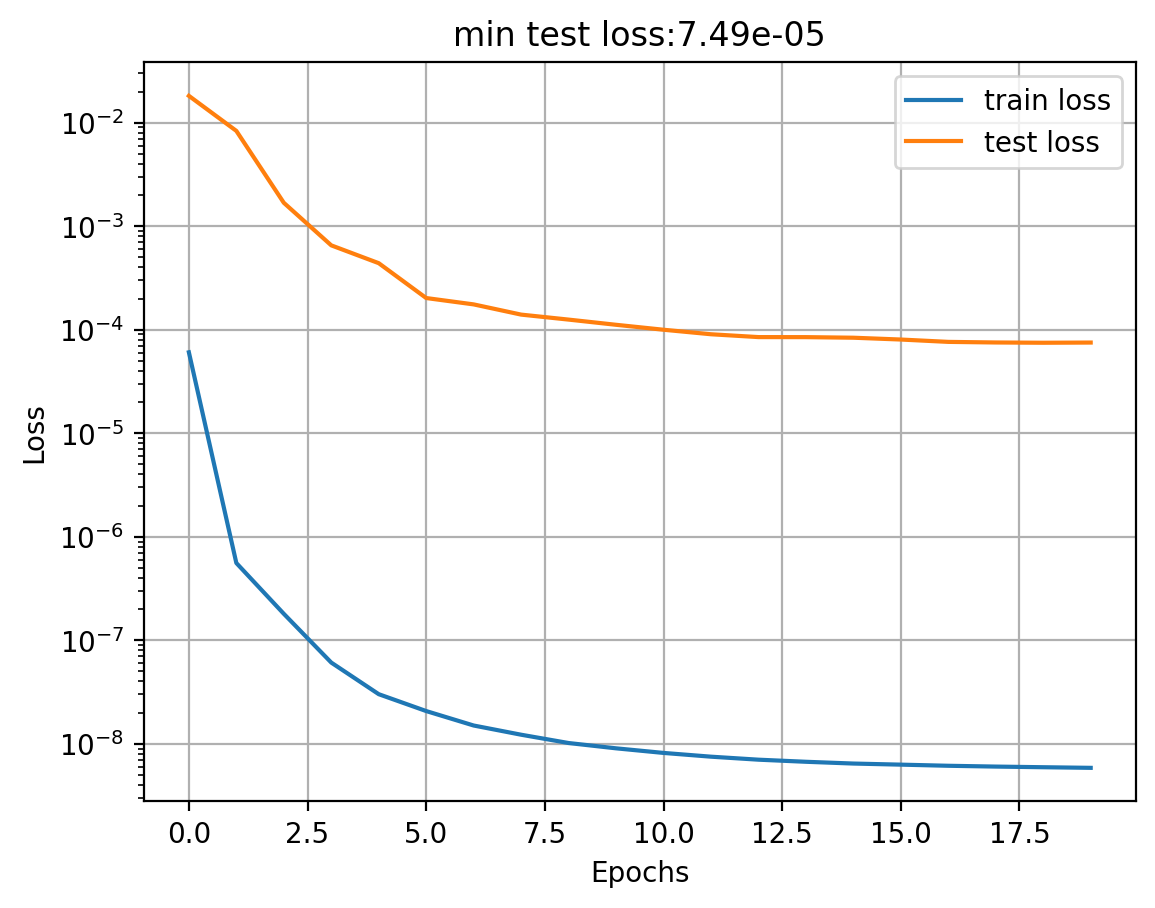

In [71]:
for k in ['train loss', 'test loss']:
    plot(t.history[k], label=k)
    
title(f'min test loss:{min(t.history["test loss"]):.3g}')
legend()
grid()
yscale('log')
ylabel('Loss')
xlabel('Epochs')

In [72]:
coscorr = lambda x,y: trace(x.T@y)/norm(x)/norm(y)


In [85]:
n = 8500
R0 = torch.linalg.pinv(X[:n].t()@X[:n]) @ (X[:n].t()@Y[:n])
L_linreg = (R0.numpy() - np.eye(R0.shape[0]))/ang

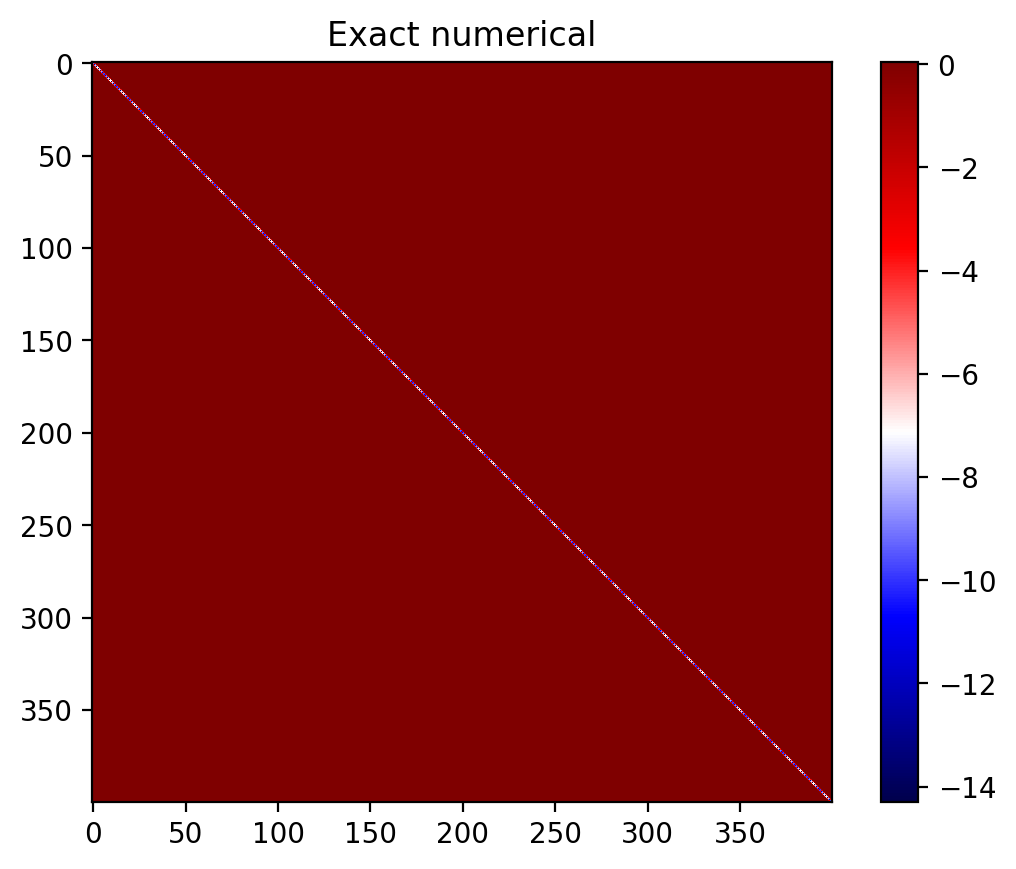

In [86]:
title('Exact numerical')
imshow(L_linreg, cmap='seismic')#, vmin = -m, vmax = m)
colorbar()

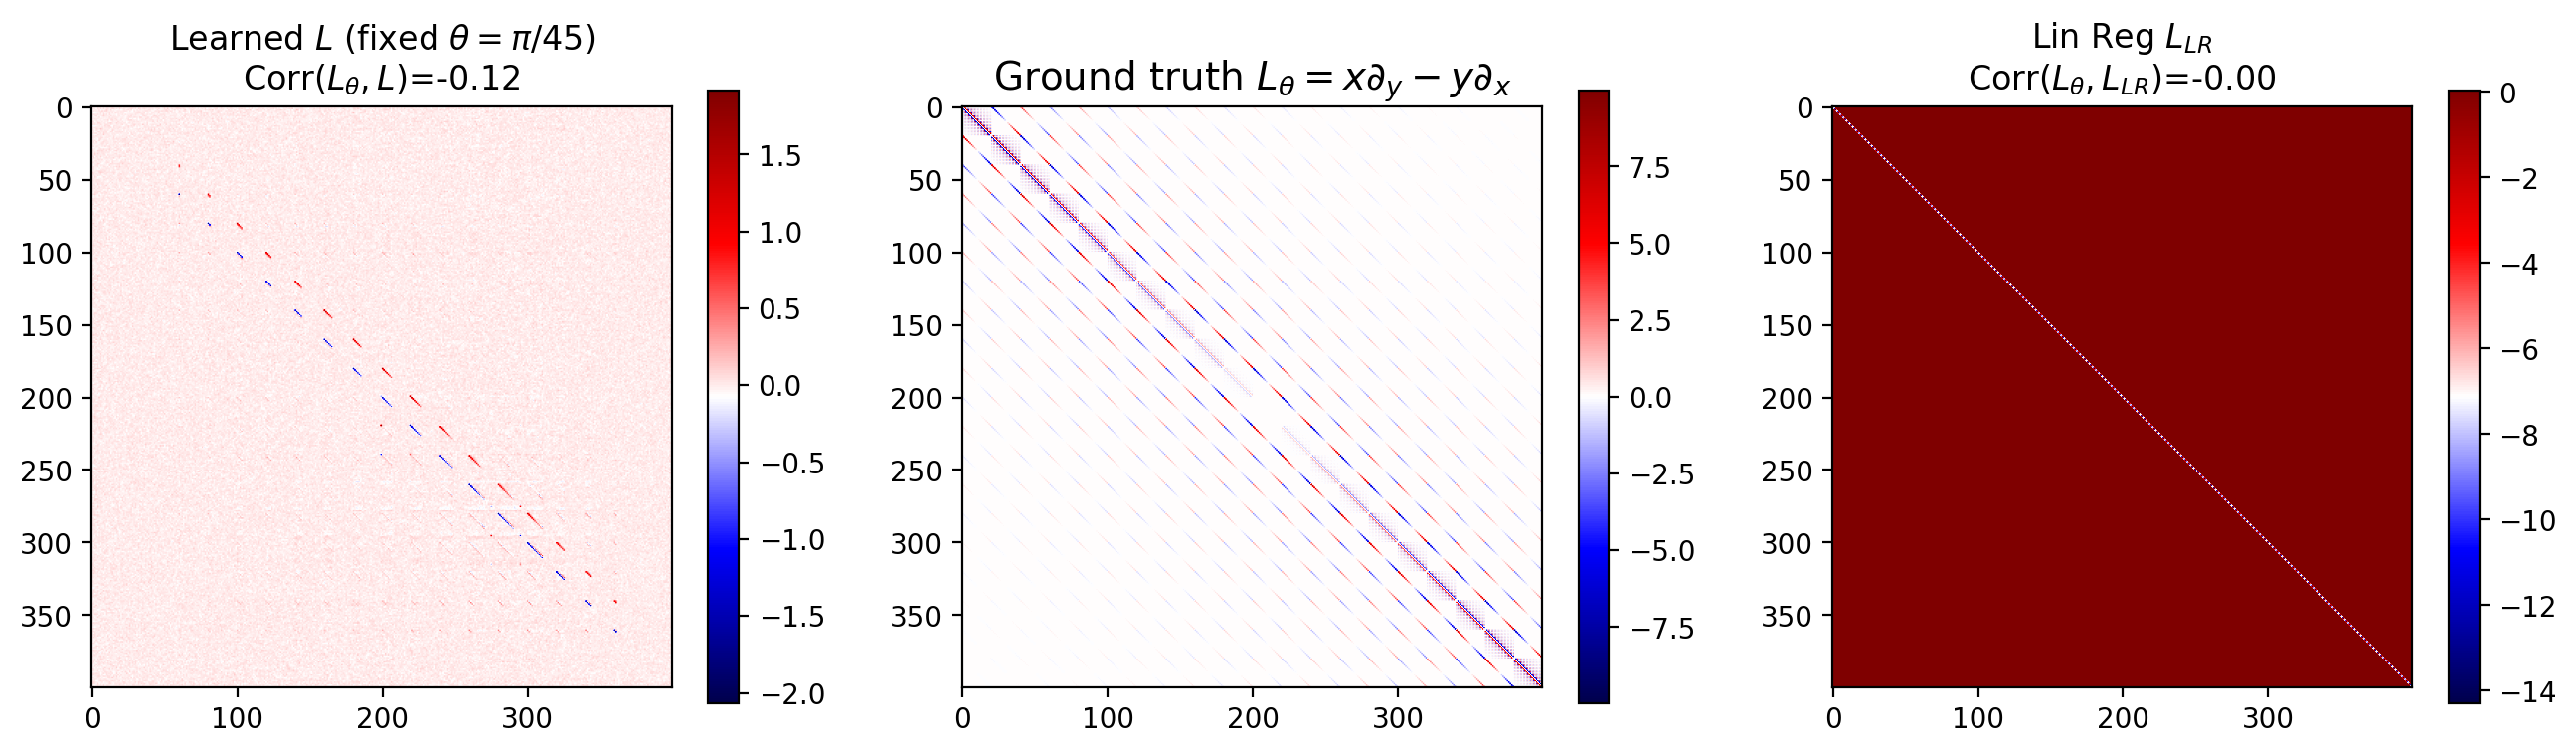

In [87]:
yLx = diag(y) @ Lx
xLy = diag(x) @ Ly

L_rot = xLy - yLx

m = L_rot.max() 

L_small = (lc.L*lc.Wi).detach().cpu().numpy()[0] / ang
lc.Wi

figure(figsize=(16,4))
subplot(131)
title(r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n)+\
      '\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_rot, L_small))
imshow(L_small, cmap='seismic')
colorbar()

subplot(132)

yLx = diag(y) @ Lx
xLy = diag(x) @ Ly

L_rot = xLy - yLx
imshow(L_rot,cmap = 'seismic')# , vmin=-m, vmax=m
colorbar()
title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);

subplot(133)

title('Lin Reg $L_{LR}$'+\
      '\n'+r'Corr($L_\theta,L_{LR}$)=%.2f'% coscorr(L_rot, L_linreg.T))
imshow(L_linreg.T, cmap='seismic')
colorbar()

# savefig('./figs2/L-so2-pi-10.pdf')
# savefig('./figs2/L-so2-pi-10.png', dpi=300)